## Experiments with Open-set Object Detection and Grounding DINO


#### Author: Antonio Rueda-Toicen

**antonio.rueda.toicen 'at' hpi 'dot' de**


[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).



 ## Open-set Object Detection

Object detection models classify and locate objects in images or videos.

![Object Detection](https://drive.google.com/uc?export=view\&id=1l81hl_UrijRdhxKSbyVvxlHn7RvU7vvk)

Traditional object detection models rely on "closed", predefined categories. However, vision-language models like [CLIP](https://openai.com/index/clip/) enable zero-shot open-set detection (also called "open vocabulary" detection) by using natural language queries without fixed categories. This can be descriptive and assign attributes (e.g. relative location within the image) to the queried label.

![Open-set Object Detection](https://drive.google.com/uc?export=view\&id=1xfxyiKVYTFbAZsnXKZeYV7jLlxPSOP38)

## Grounding DINO

The term "grounding" comes from the field of Natural Language Processing and refers to relating a word or phrase to the physical world or another data modality that represents it.
["Grounding DINO"](https://arxiv.org/abs/2303.05499) connects textual descriptions directly to image regions, enabling:

* **Language-Vision Alignment:** Mapping textual inputs to visual elements.
* **Phrase Grounding:** Formulating object detection as a phrase grounding task ([Section 3 of the paper](https://arxiv.org/pdf/2303.05499)).
* **Grounding Data:** the model has been trained on "grounding" datasets like [GoldG](https://github.com/iral-lab/gold) and [RefCOCO](https://paperswithcode.com/dataset/refcoco).
* **Cross-Modality Fusion:** Integrating language and vision features using specific mechanisms.
* **Open-Set Detection:** Detecting arbitrary objects specified by natural language.
* **Referring Expression Comprehension:** Handling complex descriptive phrases.


## Tutorial Steps

This tutorial covers:

* Downloading pretrained model
* Downloading example data
* Loading the Grounding DINO model
* Grounding DINO demonstration with exploration of its settings
* Suggested follow-up exercises


## Download the model from HuggingFace

Be sure to set up a HuggingFace token and set it up in Colab ([instructions here](https://github.com/andandandand/practical-computer-vision/blob/main/docs/huggingface-account-and-token.md)) to run this notebook.

In [69]:
import requests
import torch
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection
import matplotlib.pyplot as plt
import numpy as np # For color generation if needed

# --- Model and Processor Loading (same as before) ---
model_id = "IDEA-Research/grounding-dino-base"
# model_id = "IDEA-Research/grounding-dino-tiny" is another option with faster inference and less parameters

device = "cuda" if torch.cuda.is_available() else "cpu" # Use CUDA if available, else CPU

## Preprocessing the input

Images are scaled using the [standard scaler](https://discuss.pytorch.org/t/pytorch-tensor-scaling/38576) with mean and standard deviations derived from Grounding DINO's training data.

Text labels are tokenized using [BERT](https://en.wikipedia.org/wiki/BERT_(language_model))'s format. Remember that these labels will be turned into text embeddings to allow us to do "open vocabulary" detections. These labels can be more descriptive than in regular object detection models. For example, we can ask the model to produce a detection for "the cat on the right".    

In [70]:
# Processor describes the transformations applied to the input data (images and text labels)
processor = AutoProcessor.from_pretrained(model_id)
processor

GroundingDinoProcessor:
- image_processor: GroundingDinoImageProcessor {
  "do_convert_annotations": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "GroundingDinoImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "pad_size": null,
  "processor_class": "GroundingDinoProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

- tokenizer: BertTokenizerFast(name_or_path='IDEA-Research/grounding-dino-base', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=Fal

## Downloading and inspecting the model

In [71]:
# Download and inspect the model, send it to GPU if available
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)
model

GroundingDinoForObjectDetection(
  (model): GroundingDinoModel(
    (backbone): GroundingDinoConvModel(
      (conv_encoder): GroundingDinoConvEncoder(
        (model): SwinBackbone(
          (embeddings): SwinEmbeddings(
            (patch_embeddings): SwinPatchEmbeddings(
              (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): SwinEncoder(
            (layers): ModuleList(
              (0): SwinStage(
                (blocks): ModuleList(
                  (0): SwinLayer(
                    (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                    (attention): SwinAttention(
                      (self): SwinSelfAttention(
                        (query): Linear(in_features=128, out_features=128, bias=True)
                        (key): Linear(in_featu

## Image loading

In [72]:
# We select an image from the COCO 2017 validation set
image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# Or use a local image:
# image_path = "path/to/your/image.jpg"
# image = Image.open(image_path).convert("RGB")
try:
    image = Image.open(requests.get(image_url, stream=True).raw).convert("RGB")
except Exception as e:
    print(f"Error loading image from URL: {e}")
    print("Attempting to load a placeholder image.")
    # Create a simple placeholder image if URL fails
    try:
        from PIL import Image, ImageDraw
        img = Image.new('RGB', (600, 400), color = (73, 109, 137))
        d = ImageDraw.Draw(img)
        d.text((10,10), "Image load failed", fill=(255,255,0))
        image = img
    except ImportError:
        print("Pillow is not installed. Cannot create placeholder.")
        exit()



## Defining Open-Vocabulary Text Labels

Specify object categories using text prompts. Grounding DINO accepts:

* A list of strings for distinct concepts:

```python
  text_labels = ["a cat", "a remote control"]
```

For more specific queries, use descriptive phrases:

```python
text_labels = ["the cat to the right"]
```


This targets a specific instance based on location or attributes.




In [73]:
# Check for cats and remote controls.
# Grounding DINO can take a list of lists, where inner lists are synonyms or phrases for one concept.
# Or a simple list of strings for distinct concepts.
text_labels = ["a cat", "a remote control"] # This means "find objects that are either a cat OR a remote"

# Now we ask Grounding DINO to give a specific cat
text_labels = ["the cat to the right"]



In [74]:
# --- Inference (Getting Predictions)  ---
inputs = processor(images=image, text=text_labels, return_tensors="pt", padding=True).to(device)
with torch.inference_mode():
    outputs = model(**inputs)



In [75]:
# Inspecting the format of outputs, notice that we get not only the predictions (in logits and pred_boxes) but also hidden states for the model
outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'init_reference_points', 'intermediate_hidden_states', 'intermediate_reference_points', 'encoder_last_hidden_state_vision', 'encoder_last_hidden_state_text', 'enc_outputs_class', 'enc_outputs_coord_logits', 'encoder_logits', 'encoder_pred_boxes', 'input_ids'])



## Filtering the Output with Confidence Thresholds

After obtaining raw predictions (logits), we can apply post-processing to filter detections:

* **Box Threshold (`box_threshold`)**: Minimum confidence score for a bounding box to be considered valid.

* **Text Threshold (`text_threshold`)**: Minimum confidence score for assigning a text label to a box.

Adjust these thresholds to balance [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall).





In [76]:

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4, # Confidence threshold for a box to be considered
    text_threshold=0.3, # Confidence threshold for a label to be assigned to a box
    target_sizes=[image.size[::-1]] # (height, width)
)

result = results[0] # We process one image at a time
print(f"Detected {len(result['scores'])} objects.")



Detected 1 objects.


In [77]:
# Create a drawable version of the image
draw = ImageDraw.Draw(image)

# Define some colors for different labels (optional, can cycle or use a fixed color)
# Get unique labels to assign colors
unique_labels = list(set(result["labels"]))
# Generate some distinct colors
# Using a simple approach with a predefined list, cycling if more labels than colors
palette = ["red", "green", "blue", "yellow", "purple", "orange", "cyan", "magenta"]
label_to_color = {label: palette[i % len(palette)] for i, label in enumerate(unique_labels)}

## Plotting the bounding boxes

Detected 'the cat to the right' with confidence 0.797 at location [346.95, 23.33, 639.38, 373.04]


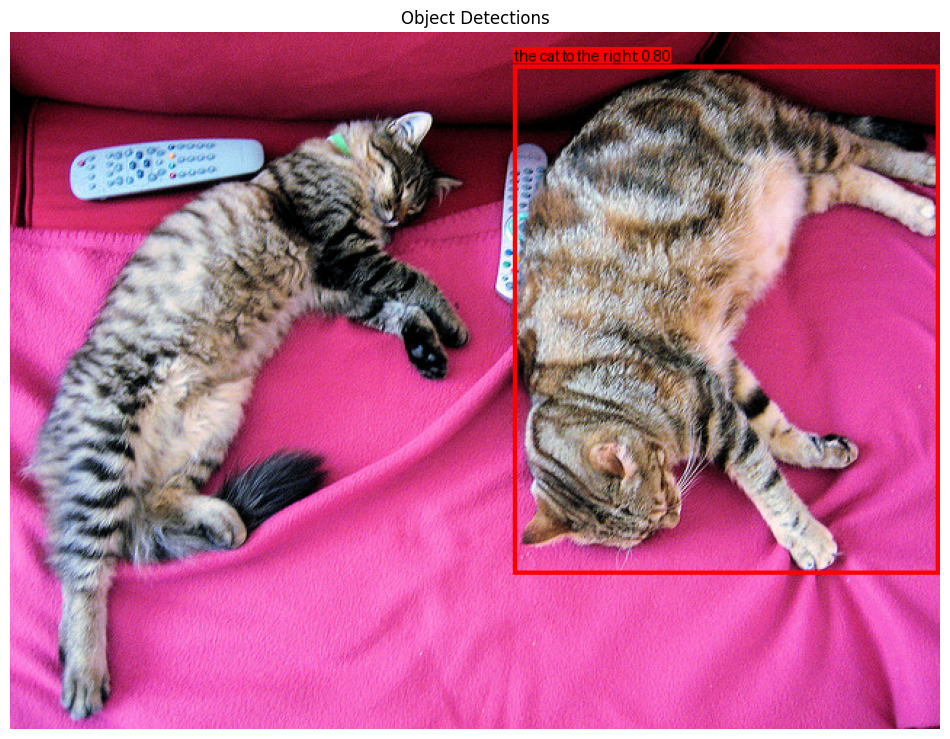

In [78]:
for box_tensor, score_tensor, label_str in zip(result["boxes"], result["scores"], result["labels"]):
    box = [round(i, 2) for i in box_tensor.tolist()] # [xmin, ymin, xmax, ymax]
    score = round(score_tensor.item(), 3)
    color = label_to_color.get(label_str, "white") # Default to white if label somehow not in map

    # Draw bounding box
    draw.rectangle(box, outline=color, width=3)

    # Prepare text: label and confidence
    text = f"{label_str}: {score:.2f}"

    # Calculate text size and position
    # For PIL versions < 9.2.0, textsize is used. For >= 9.2.0, textbbox is preferred.
    try:
        text_bbox = draw.textbbox((box[0], box[1]), text)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
    except AttributeError: # Fallback for older PIL
        text_width, text_height = draw.textsize(text)


    # Position text slightly above the box, or inside if it goes off-screen
    text_x = box[0]
    text_y = box[1] - text_height - 2 # A little padding above the box

    if text_y < 0: # If text goes off the top screen, place it inside the box at the top
        text_y = box[1] + 2
    if text_x + text_width > image.width: # If text goes off the right screen
        text_x = image.width - text_width -2


    # Draw a filled rectangle as a background for the text for better visibility
    draw.rectangle(
        [text_x, text_y, text_x + text_width, text_y + text_height],
        fill=color
    )
    # Draw the text
    draw.text((text_x, text_y), text, fill="black") # Black text on colored background

    print(f"Detected '{label_str}' with confidence {score} at location {box}")

# --- Display the image with detections ---
plt.figure(figsize=(12, 12)) # You can adjust the figure size
plt.imshow(image)
plt.axis('off') # Hide axes
plt.title("Object Detections")
plt.show()



## Saving the output to disk

In [79]:
# If you want to save the image:
image.save("detections_output.jpg")
print("Saved image with detections to detections_output.jpg")

Saved image with detections to detections_output.jpg


In [80]:
!ls

detections_output.jpg  sample_data


## Optional: GPU Acceleration

In Google Colab, we can get faster inference (useful when working on multiple images) if we enable GPU acceleration via `Edit` → `Notebook settings` → `Hardware accelerator` → `GPU`.

## Follow-Up Exercises

Now that you've run Grounding DINO for zero-shot object detection, here are some exercises to further explore its capabilities.

**1. Experiment with Diverse Text Prompts:**

*   **Goal:** Understand how Grounding DINO interprets different types of text prompts.
*   **Tasks:**
    *   **Descriptive Prompts:** Try more descriptive prompts like:
        *   `"a sleeping cat"`
        *   `"a remote control on a soft surface"`
        *   `"a person's hand holding a remote"` (if applicable to an image)
    *   **Abstract or Complex Concepts:** Test prompts for things that might be harder to define visually or are more conceptual, e.g., `"signs of activity"`, `"a comfortable spot"`.
    *   **Negative Prompts (Conceptual):** While Grounding DINO isn't explicitly designed for negative prompting in the detection query itself, consider what happens if you prompt for something clearly not in the image.
    *   **Synonyms:** Experiment with the synonym capability more. For example, if you have an image with a dog, try `[["a dog", "a canine", "a puppy"]]`. Does it improve detection or change confidence scores?
*   **Questions to Consider:**
    *   How does the specificity of your prompt affect the detections?
    *   Does the model successfully ground complex phrases or attributes to the correct objects?

**2. Image Variety and Robustness:**

*   **Goal:** Assess the model's performance on different types of images.
*   **Tasks:**
    *   **Use Your Own Images:** Modify the image loading part to use your own images. Try:
        *   Images with many objects.
        *   Images with very few objects.
        *   Cluttered scenes.
        *   Images where objects are small, partially occluded, or in unusual lighting.
        *   Images downloaded from the web with diverse content.
    *   **Placeholder Image Test:** Intentionally cause the URL image loading to fail (e.g., by providing a bad URL) to see the placeholder image generation in action.
*   **Questions to Consider:**
    *   How does image quality, clutter, object size, and occlusion affect detection performance?
    *   Are there particular types of scenes or objects the model struggles with?

**3. Hyperparameter Tuning: Thresholds:**

*   **Goal:** Understand the impact of `box_threshold` and `text_threshold` on the detection results.
*   **Tasks:**
    *   Systematically vary the `box_threshold` (e.g., try values like 0.2, 0.4, 0.6, 0.8) while keeping `text_threshold` constant. Observe how the number of detected boxes changes.
    *   Systematically vary the `text_threshold` (e.g., try values like 0.1, 0.3, 0.5, 0.7) while keeping `box_threshold` constant. Observe how the labels assigned to boxes (and the boxes themselves, if they no longer have a confident label) change.
*   **Questions to Consider:**
    *   What is the trade-off when increasing/decreasing these thresholds (e.g., precision vs. recall)?
    *   How do these thresholds interact? Is there an optimal combination for certain types of scenes or prompts?

**4. Model Variation (Size & Performance):**

*   **Goal:** Compare different versions of the Grounding DINO model.
*   **Tasks:**
    *   The current `model_id` is `"IDEA-Research/grounding-dino-tiny"`. Check the [Hugging Face Model Hub](https://huggingface.co/models?search=grounding-dino) for other variants like `"IDEA-Research/grounding-dino-base"`.
    *   If you find other variants, try loading one (e.g., `grounding-dino-base`) and repeat some detections.
    *   **Note:** Larger models might require more VRAM and take longer to download and run.
*   **Questions to Consider:**
    *   Is there a noticeable difference in detection quality or the ability to understand complex prompts with a larger model?
    *   How does the inference speed compare?

**5. Visualization:**

*   **Goal:** Improve the visual output of the detections.
*   **Tasks:**
    *   **Font Customization:** The current plotting code uses the default plotting font, which might not be the nicest.
        *   Add `from PIL import ImageFont`
        *   Before the loop, load a font:
            ```python
            try:
                # Try to load a specific font (e.g., Arial, DejaVuSans)
                font = ImageFont.truetype("arial.ttf", 15) # Adjust font and size
            except IOError:
                # Fallback to a default font if the specific one isn't found
                font = ImageFont.load_default()
            ```
        *   Ensure this `font` object is used in `draw.textbbox` (or `draw.textsize`) and `draw.text`. You might need to install a font file or use one known to be on your system.
    *   **Dynamic Color Palette:** The current color palette is fixed. If you detect more unique labels than colors in `palette`, colors will repeat.
        *   Implement a more dynamic way to assign colors, perhaps using a colormap from `matplotlib.cm` or a hashing function on the label string to generate somewhat consistent colors.
    *   **Text Legibility:** Experiment with text background opacity or outline color for better legibility across different image backgrounds.
*   **Questions to Consider:**
    *   How does a clearer font improve the visualization?
    *   What are the pros and cons of different color assignment strategies?

**6. Handling No Detections:**

*   **Goal:** Make the script more robust when no objects are found.
*   **Tasks:**
    *   Modify the script to provide a more user-friendly message if `len(result['scores'])` is 0. For example, instead of just "Detected 0 objects.", print something like "No objects found matching your prompts with the current thresholds."
*   **Questions to Consider:**
    *   Why is it important to handle such cases gracefully in an application?

**7. Performance Measurement:**

*   **Goal:** Quantify the inference speed of the model.
*   **Tasks:**
    *   Use the `time` module to measure the duration of the inference step:
        ```python
        import time
        # ...
        start_time = time.time()
        with torch.no_grad():
            outputs = model(**inputs)
        # Potentially include post-processing in the timing too
        results = processor.post_process_grounded_object_detection(...)
        end_time = time.time()
        print(f"Inference and post-processing took: {end_time - start_time:.4f} seconds")
        ```
    *   If you have access to both CPU and GPU, compare the inference times by changing the `device` variable.
*   **Questions to Consider:**
    *   How does model size (if you tried exercise 4) affect inference time?
    *   What are the implications of inference speed for real-time applications?

**8. Batch Processing (Advanced):**

*   **Goal:** Adapt the code to process multiple images in a single batch.
*   **Tasks:**
    *   Create a list of PIL Images: `images_batch = [image1, image2, image3]` (load several different images).
    *   Modify the `processor` call: `inputs = processor(images=images_batch, text=text_labels, return_tensors="pt").to(device)`
    *   The `target_sizes` for `post_process_grounded_object_detection` will need to be a list of tuples, one for each image: `target_sizes=[img.size[::-1] for img in images_batch]`.
    *   Adapt the plotting loop to iterate through the `results` list (which will now contain detections for each image in the batch).
*   **Questions to Consider:**
    *   Does batching improve overall throughput (total images processed per unit time)?
    *   What are the memory implications of batching?

These exercises should provide a solid foundation for working with and understanding zero-shot object detectors like Grounding DINO. Happy coding!

## Acknowledgements

Many thanks to Sedigheh Eslami and Johanna Reiml for help and discussions on this notebook.